# Brute Force Ising Model
### Introduction
The objective of this notebook is to attempt to observe a magnetic transition in a 2D Ising model using a brute force, random sampling approach

Broadly, we want to test many configurations for each temperature, determine the average magnetic moment and energy, and plot each of these as a function of temperature. 

As a first guess, consider randomly sampling distributions and simply taking the average

$$ \langle M \rangle = \frac{\sum_j^N M_j}{N} \quad \langle E \rangle = \frac{\sum_j^N E_j}{N}$$

However, this fails because randomly sampled distributions are often not representative of the most likely states. For example, consider a ferromagnetic system at low temperatures. Using our Hamiltonian, we expect this system to be fully ordered with parallel spins. 
<img src="./parallel.png" alt="parallel" width="280">Yet, there are only 2 configurations (all spin up and all spin down) of the $2^{n_{spins}}$ combinations. Random selection tends to result in disordered, even spin up/down configurations, i.e. shuffling a deck of cards yields 'random' results, not ordered configurations
### Statistical mechanics
Instead of equally weighting all configurations, we can improve our model if we instead weigh each configuration by the probability from a **Boltzmann distribution**
This probability of finding a given state is given by
$$ P = \frac{e^{-\beta H}}{Z} $$
Where $\beta = \frac{1}{k_bT}$ and $Z$ is the **partition function**, given by 
$$ Z = \sum_{states}e^{-\beta H} $$
This accounts for the lack of sampling ordered states. However, the partition function requires calculating energies of *all of the given states*, which scales as $2^{n_{spins}}$. This is pretty inefficient (i.e. for a 16x16 grid, $2^{16*16}\approx n_{\text{atoms in universe}}$). 

### Modified statistical mechanics
Instead, we're limited to an approximation of the partition function; that is, 

$$ Z = \sum_{\text{sampled states}}e^{-\beta H} $$

This results in the equations for average magnetism and energy given below

$$ \langle M\rangle = \frac{\sum_jM_j * e^{-\beta E_j}}{\sum_j {e^{-\beta E_j}}}$$

$$ \langle E\rangle = \frac{\sum_jE_j * e^{-\beta E_j}}{\sum_j {e^{-\beta E_j}}}$$


### Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from numba import jit

### Create functions for generating random configurations, calculating energy and magnetism

In [3]:
# Function to create random square array
def gen_random_conf(n):
    # input: n = length of array = width of array
    # output: random n x n array (-1's and +1's)
    
    A = np.random.choice([-1,1], size=(n,n))
    
    return(A)

In [4]:
@jit(nopython=True)
# Calculate energy of a given spin array
def calculate_energy(spin):
    
    #Determine if array is square
    spin_shape = spin.shape
    
    #End if array is not square
    if spin_shape[0] != spin_shape[1]:
        print("This is not a square matrix")
        
    #Continues code if array is square    
    elif spin_shape[0] == spin_shape[1]:
        N = spin_shape[0]
        
        energy = 0
        J = 1 # ferromagnetic

        for i in range(N):  # 0, N-1
          for j in range(N): # 0, N-1
            # Calculate four interactions
            ii = i + -1
            if (ii < 0): 
                ii = ii + N
            if (ii >=N): 
                ii = ii - N
            energy = energy + spin[i,j]*spin[ii, j] 

            
            jj = j + -1
            if (jj < 0): 
                jj = jj + N
            if (jj >=N): 
                jj = jj - N
            energy = energy + spin[i,j]*spin[i, jj] 

        energy = -J * energy * 0.5
    
    return energy

In [5]:
# Sums all indices of array (magnetic moment)
def magnetism_sum(spin):
    magnetism = np.sum(spin)
    return magnetism

### Generating M vs. T and E vs. T plots

In [6]:
# Number of configurations that will contribute to averages
iterations = 10000
# Array size
N = 10

# Intializing arrays
beta_array, temp_array, energy_array, mag_array = [], [], [], []

# Determing beta based on temperature & initializing variables/resetting variables after each loop
for temp in np.linspace(0.0001, 1, 100):
    beta = 1/temp # J/kT
    energy = 0.
    magnetism = 0. 
    denominator = 0. 
    
    # Generates given number of configurations and considers their energies/magnetizations in the averages
    for i in range(iterations):
        # Creates new random configuration
        spin = gen_random_conf(N)
        
        # Calculates the magnetism of configuration
        mag = np.sum(spin)/N**2 

        # Calculates the energy of configuration
        e = calculate_energy(spin)/N**2
        
        # Determines bolztman weight
        boltz = np.exp(-1*beta*e)
        # Values are included in the summations(numerators of equations for avg. magetism and energy)
        energy += e * boltz
        magnetism += mag * boltz
        denominator += boltz
    
    # Calculates average magnetism and energy
    magnetism = magnetism/denominator
    energy = energy/denominator

    # Adds values to arrays
    beta_array.append(beta)
    temp_array.append(1/beta)
    energy_array.append(energy)
    mag_array.append(abs(magnetism))

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


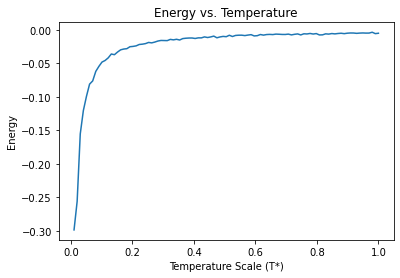

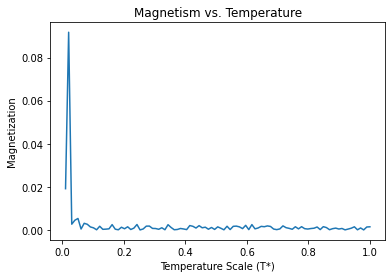

In [7]:
# Generate plots of energy and magnetism vs. temperature
plt.title("Energy vs. Temperature") 
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Energy"); 
plt.plot(temp_array, energy_array) 
plt.show()

plt.title("Magnetism vs. Temperature")  
plt.xlabel("Temperature Scale (T*)"); 
plt.ylabel("Magnetization"); 
plt.plot(temp_array, mag_array)

plt.show()

## Conclusions
We see that the brute force approach does not show a phase transition or any magnetic order.

The E vs. T graph generally follows the Boltzmann distribution, but without calculating the full partition function a magnetic transition is not observed

How can we take a problem which would take the age of the universe to compute, and solve it in a few minutes on a laptop? By implementing a [monte carlo approach](Monte%20Carlo%20Ising%20Model.ipynb)